In [1]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from data.data_loader import generateGauss
from utils.integral import grid
from Models.classification import Logistics
from utils.vis import plot_beta, temp

In [3]:
h = 0.01
x_grid = grid(h, start=-2, end=12)

mu_A = [1, 1.5, 2, 2.5, 6]
sig_A = 0.4 * np.ones_like(mu_A)
mu_B = [4.5, 7.5, 8.5, 8, 9.0]
sig_B = 0.9 * np.ones_like(mu_A)

class1_data = generateGauss(mu_A, sig_A, x_grid)
class2_data = generateGauss(mu_B, sig_B, x_grid)
all_pdfs = np.vstack([class1_data, class2_data])

print(all_pdfs.shape)

y = np.array([0]*len(class1_data) + [1]*len(class2_data))
n_A, n_B = len(class1_data), len(class2_data)

(10, 1401)


In [4]:
import numpy as np
from scipy.integrate import trapezoid

# -------------------------------------------------
# 1. CHỌN BASIS Ở ĐÂY (thay tên hàm tương ứng)
# -------------------------------------------------
basis_functions = Logistics.FLR.generate_gaussian_basis(x_grid, M=10)
# basis_functions = Logistics.FLR.generate_fourier_basis(x_grid, M=20)
# basis_functions = Logistics.FLR.generate_bspline_basis(x_grid, M=10, degree=6)
# basis_functions = Logistics.FLR.generate_sigmoid_basis(x_grid, M=10)

# -------------------------------------------------
# 2. Tính moments (n_samples x n_basis)
# -------------------------------------------------
moments = np.array([
    [trapezoid(f * psi, x=x_grid) for psi in basis_functions]
    for f in all_pdfs
])

# -------------------------------------------------
# 3. Thêm intercept và huấn luyện
# -------------------------------------------------
X_design = np.hstack([np.ones((moments.shape[0], 1)), moments])

model_flr = Logistics.Model(n_iter=1000, l1_penalty=.01, l2_penalty=0.001, verbose=False)
model_flr.fit(X_design, y)

# -------------------------------------------------
# 4. In tóm tắt
# -------------------------------------------------
print(model_flr.summary())

Logistic Regression Summary

No. Observations:        10
Model:                   Logistic (L-BFGS-B)
Log-Likelihood:          -0.6448	Pseudo R-squared:        0.9070
AIC:                     23.2895	BIC:                     26.6180
No. Features:            10		Non-zero Coeffs:         7
Accuracy:                1.0000		Precision:               1.0000
Recall:                  1.0000		F1-Score:                1.0000
ROC-AUC:                 1.0000

------------------------------------------------------------------------------
Variable            Coef      |Coef|     Std.Err         z       p>|z|
------------------------------------------------------------------------------
Intercept         1.1860      1.1860   1218.4722     0.001      0.9992
X1                0.0000      0.0000   9999.1598     0.000      1.0000
X2               -0.0000      0.0000    900.0377    -0.000      1.0000
X3               -6.3323      6.3323   1109.1544    -0.006      0.9954
X4               -5.4817      5.481

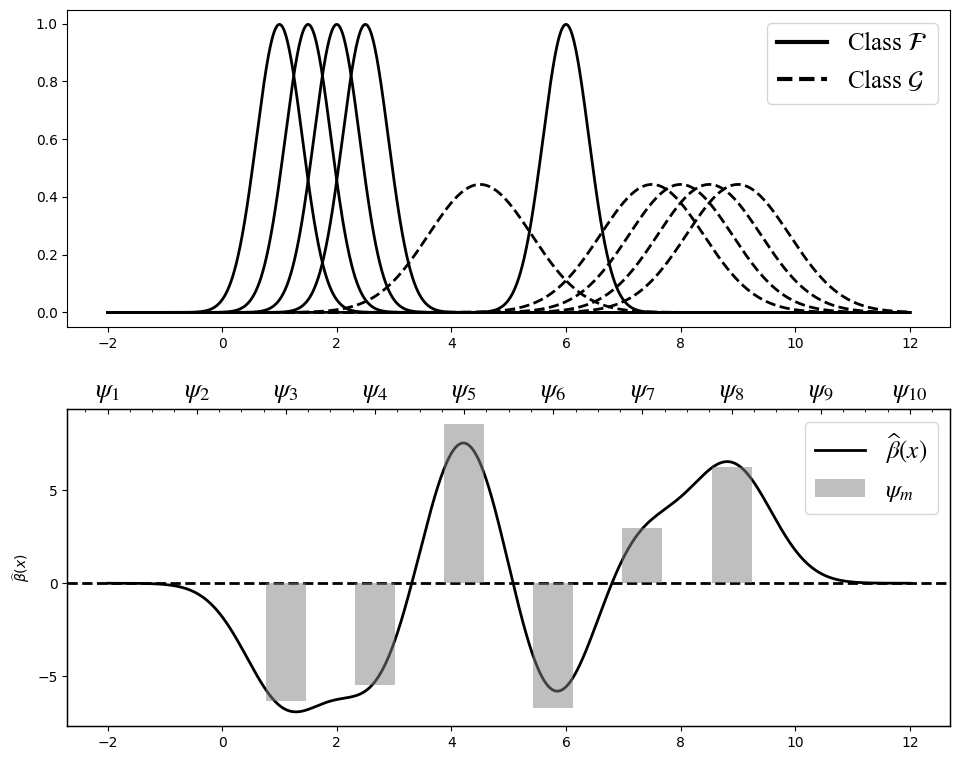

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
temp(20)
# -------------------------------------------------
# 1) PDFs in the upper row
# -------------------------------------------------
for i in range(len(all_pdfs)):
    if y[i] == 0:
        axes[0].plot(x_grid, all_pdfs[i], lw=2, color='black', linestyle='-')
    else:
        axes[0].plot(x_grid, all_pdfs[i], lw=2, color='black', linestyle='--')

# Thêm legend
axes[0].plot([], [], lw=3, color='black', linestyle='-', label=r'Class $\mathcal{F}$')
axes[0].plot([], [], lw=3, color='black', linestyle='--', label=r'Class $\mathcal{G}$')
axes[0].legend()

# -------------------------------------------------
# 2) Beta function in the lower row
# -------------------------------------------------
beta_vals = np.asarray(model_flr.coef_vector_)
w = sum(b * psi for b, psi in zip(beta_vals, basis_functions))

# Main line for β̂(x)
line, = axes[1].plot(x_grid, w, color='black', lw=2, label=r'$\widehat{\beta}(x)$')
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_ylabel(r'$\widehat{\beta}(x)$')

# Secondary x-axis (top) for the basis bars
ax2 = axes[1].twiny()
M = len(beta_vals)
x_pos = np.linspace(x_grid.min(), x_grid.max(), M)
bars = ax2.bar(
    x_pos, beta_vals,
    width=(x_grid.max() - x_grid.min()) / (M * 2),
    color='gray', alpha=0.5, label=r'$\psi_m$'
)

ax2.set_xticks(x_pos)
ax2.set_xticklabels([fr'$\psi_{{{i+1}}}$' for i in range(M)])
ax2.set_xlim(axes[1].get_xlim())

# Combine legends
lines = [line, bars]
labels = [l.get_label() for l in lines]
axes[1].legend(lines, labels, loc='best')

plt.tight_layout()
# fig.savefig("C1_beta_log.pdf", bbox_inches='tight')

In [6]:
# Dùng trực tiếp vector mật độ tại lưới
X_dlr = all_pdfs
X_dlr = np.column_stack([np.ones(X_dlr.shape[0]), X_dlr])

# Huấn luyện
model_dlr = Logistics.Model(l1_penalty=0.01, l2_penalty=0.001, verbose=False)
model_dlr.fit(X_dlr, y)
print(model_dlr.summary(X=X_dlr,y=y))

Logistic Regression Summary

No. Observations:        10
Model:                   Logistic (L-BFGS-B)
Log-Likelihood:          -0.4469	Pseudo R-squared:        0.9355
AIC:                     2804.8938	BIC:                     3229.1181
No. Features:            1401		Non-zero Coeffs:         1381
Accuracy:                1.0000		Precision:               1.0000
Recall:                  1.0000		F1-Score:                1.0000
ROC-AUC:                 1.0000

------------------------------------------------------------------------------
Variable            Coef      |Coef|     Std.Err         z       p>|z|
------------------------------------------------------------------------------
Intercept         3.9884      3.9884   9514.1599     0.000      0.9997
X1               -0.0000      0.0000  10000.0000    -0.000      1.0000
X2               -0.0000      0.0000  10000.0000    -0.000      1.0000
X3               -0.0000      0.0000   9999.9999    -0.000      1.0000
X4               -0.0000  

In [7]:
h_new = generateGauss([3], [0.9], x_grid)
moments = np.array([
    [trapezoid(f * psi, x=x_grid) for psi in basis_functions]
    for f in h_new
])

X_new = np.hstack([np.ones((moments.shape[0], 1)), moments])

pred_class = model_flr.predict(X_new)[0]
prob       = model_flr.predict_proba(X_new)[0]

print("Predicted class:", pred_class)
print("Predict prob. ", prob)

Predicted class: 0
Predict prob.  0.4326368583066541


In [8]:
h_new = generateGauss([3], [0.9], x_grid) 
h_new = np.hstack([h_new, [[1.0]]])         

pred_class = model_dlr.predict(h_new)[0]
prob       = model_dlr.predict_proba(h_new)[0]

print("Predicted class:", pred_class)
print("Predict prob. ", prob)

Predicted class: 0
Predict prob.  0.022825408072626514
